
Distribution of Financial Tiers Across Communities:
Tier       High  Low  Medium
Community                   
0            59  138      86
1            85  170     106
2           150   27      43
3           101  125     101
4            80   91     109
5             0    1       0
6           106   57     162
7             1    0       0
8            61  114      78
10           55   42      62
11            0    0       1
12          188  131     207
13          134  127      61
14            0    0       1


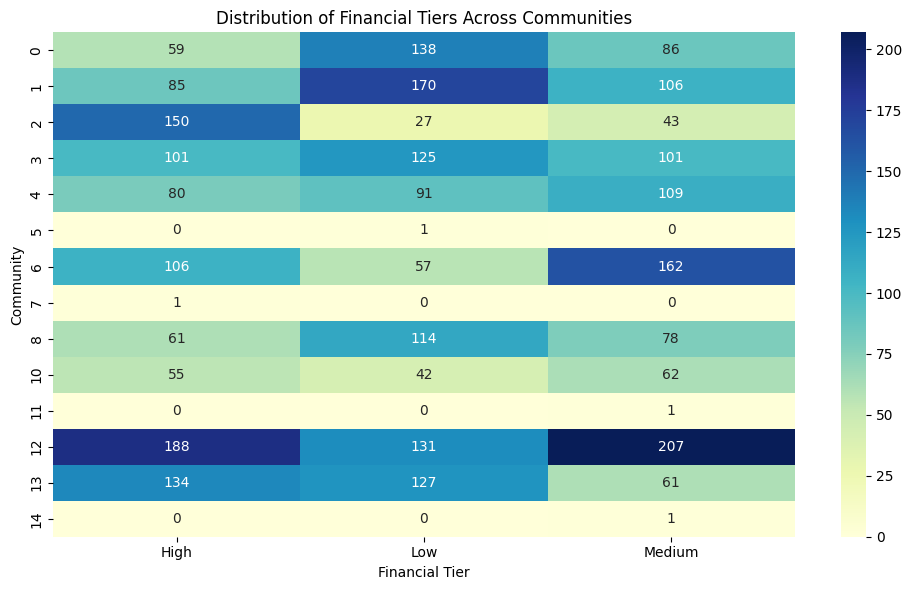

In [ ]:
# Community vs. Financial Tier Analysis in Football Transfer Network

# Importing required libraries
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain  # For detecting communities
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset from the Excel file
file_path = "Transfer-Players-Clubs.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Clean the financial column by removing currency symbols and converting to numeric
df['net_transfer_record_clean'] = df['net_transfer_record'].str.replace(r'[^\d.-]', '', regex=True).astype(float)

# Calculate average net transfer spend per club
club_finance = df.groupby('from_club_name')['net_transfer_record_clean'].mean().to_dict()

# Assign each club to a financial tier (Low, Medium, or High) using quantiles
quantiles = pd.qcut(list(club_finance.values()), q=3, labels=["Low", "Medium", "High"])
club_tiers = dict(zip(club_finance.keys(), quantiles))

# Create a directed graph where edges represent transfers between clubs
G = nx.DiGraph()
for _, row in df.iterrows():
    from_club = row['from_club_name']
    to_club = row['to_club_name']
    if pd.notnull(from_club) and pd.notnull(to_club):  # Only add if both values are valid
        G.add_edge(from_club, to_club)

# Convert the graph to undirected for Louvain community detection
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)

# Collect club, community, and tier info into a list
node_data = []
for node in G_undirected.nodes():
    community = partition.get(node)
    tier = club_tiers.get(node)
    if tier is not None:  # Skip clubs without tier data
        node_data.append((node, community, tier))

# Create a DataFrame with community and tier information
node_df = pd.DataFrame(node_data, columns=["Club", "Community", "Tier"])

# Count the number of clubs per community per financial tier
tier_dist_by_community = node_df.groupby(["Community", "Tier"]).size().unstack(fill_value=0)
print("\nDistribution of Financial Tiers Across Communities:")
print(tier_dist_by_community)

# Visualize the distribution as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(tier_dist_by_community, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Distribution of Financial Tiers Across Communities")
plt.xlabel("Financial Tier")
plt.ylabel("Community")
plt.tight_layout()
plt.show()
